In [55]:
import pandas as pd
import math
import csv
import random
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt

In [3]:
# 当每支队伍没有elo等级分时，赋予其基础elo等级分
base_elo = 1600
team_elos = {} 
team_stats = {}
X = []
y = []
folder = 'data' #存放数据的目录

In [4]:
# 根据每支队伍的Miscellaneous Opponent，Team统计数据csv文件进行初始化
def initialize_data(Mstat, Ostat, Tstat):
    new_Mstat = Mstat.drop(['Rk', 'Arena'], axis=1)
    new_Ostat = Ostat.drop(['Rk', 'G', 'MP'], axis=1)
    new_Tstat = Tstat.drop(['Rk', 'G', 'MP'], axis=1)

    team_stats1 = pd.merge(new_Mstat, new_Ostat, how='left', on='Team')
    team_stats1 = pd.merge(team_stats1, new_Tstat, how='left', on='Team')
    return team_stats1.set_index('Team', inplace=False, drop=True)

In [5]:
def get_elo(team):
    try:
        return team_elos[team]
    except:
        # 当最初没有elo时，给每个队伍最初赋base_elo
        team_elos[team] = base_elo
        return team_elos[team]

In [6]:
# 计算每个球队的elo值
def calc_elo(win_team, lose_team):
    winner_rank = get_elo(win_team)
    loser_rank = get_elo(lose_team)

    rank_diff = winner_rank - loser_rank
    exp = (rank_diff  * -1) / 400
    odds = 1 / (1 + math.pow(10, exp))
    # 根据rank级别修改K值
    if winner_rank < 2100:
        k = 32
    elif winner_rank >= 2100 and winner_rank < 2400:
        k = 24
    else:
        k = 16

    # 更新 rank 数值
    new_winner_rank = round(winner_rank + (k * (1 - odds)))      
    new_loser_rank = round(loser_rank + (k * (0 - odds)))
    return new_winner_rank, new_loser_rank

In [7]:
def  build_dataSet(all_data):
    print("Building data set..")
    X = []
    skip = 0
    for index, row in all_data.iterrows():

        Wteam = row['WTeam']
        Lteam = row['LTeam']

        #获取最初的elo或是每个队伍最初的elo值
        team1_elo = get_elo(Wteam)
        team2_elo = get_elo(Lteam)

        # 给主场比赛的队伍加上100的elo值
        if row['WLoc'] == 'H':
            team1_elo += 100
        else:
            team2_elo += 100

        # 把elo当为评价每个队伍的第一个特征值
        team1_features = [team1_elo]
        team2_features = [team2_elo]

        # 添加我们从basketball reference.com获得的每个队伍的统计信息
        for key, value in team_stats.loc[Wteam].iteritems():
            team1_features.append(value)
        for key, value in team_stats.loc[Lteam].iteritems():
            team2_features.append(value)

        # 将两支队伍的特征值随机的分配在每场比赛数据的左右两侧
        # 并将对应的0/1赋给y值
        if random.random() > 0.5:
            X.append(team1_features + team2_features)
            y.append(0)
        else:
            X.append(team2_features + team1_features)
            y.append(1)

        if skip == 0:
            print('X',X)
            skip = 1

        # 根据这场比赛的数据更新队伍的elo值
        new_winner_rank, new_loser_rank = calc_elo(Wteam, Lteam)
        team_elos[Wteam] = new_winner_rank
        team_elos[Lteam] = new_loser_rank

    return np.nan_to_num(X), y

In [8]:
if __name__ == '__main__':

    Mstat = pd.read_csv(folder + '/15-16Miscellaneous_Stat.csv')
    Ostat = pd.read_csv(folder + '/15-16Opponent_Per_Game_Stat.csv')
    Tstat = pd.read_csv(folder + '/15-16Team_Per_Game_Stat.csv')

    team_stats = initialize_data(Mstat, Ostat, Tstat)

    result_data = pd.read_csv(folder + '/2015-2016_result.csv')
    X, y = build_dataSet(result_data)

    # 训练网络模型
    print("Fitting on %d game samples.." % len(X))

    model = linear_model.LogisticRegression()
    model.fit(X, y)

    #利用10折交叉验证计算训练正确率
    print("Doing cross-validation..")
    print(cross_val_score(model, X, y, cv = 10, scoring='accuracy', n_jobs=-1).mean())

Building data set..
('X', [[1600, 28.199999999999999, 48.0, 34.0, 51.0, 31.0, 3.6099999999999999, -0.12, 3.4900000000000002, 105.09999999999999, 101.40000000000001, 97.099999999999994, 0.23699999999999999, 0.33600000000000002, 0.55200000000000005, 0.51600000000000001, 13.800000000000001, 19.100000000000001, 0.185, 0.47999999999999998, 14.4, 74.599999999999994, 0.19399999999999998, 690150.0, 37.100000000000001, 86.099999999999994, 0.43200000000000005, 8.3000000000000007, 24.5, 0.33799999999999997, 28.899999999999999, 61.600000000000001, 0.46899999999999997, 16.699999999999999, 22.100000000000001, 0.755, 11.5, 35.0, 46.5, 22.0, 8.5999999999999996, 5.0, 16.100000000000001, 18.300000000000001, 99.200000000000003, 38.600000000000001, 84.400000000000006, 0.45799999999999996, 9.9000000000000004, 28.399999999999999, 0.34999999999999998, 28.699999999999999, 56.100000000000001, 0.51200000000000001, 15.6, 20.0, 0.78299999999999992, 8.3000000000000007, 33.799999999999997, 42.100000000000001, 25.60

In [9]:
def predict_winner(team_1, team_2, model):
    features = []

    # team 1，客场队伍
    features.append(get_elo(team_1))
    for key, value in team_stats.loc[team_1].iteritems():
        features.append(value)

    # team 2，主场队伍
    features.append(get_elo(team_2) + 100)
    for key, value in team_stats.loc[team_2].iteritems():
        features.append(value)

    features = np.nan_to_num(features)
    return model.predict_proba([features])

In [10]:
# 利用训练好的model在16-17年的比赛中进行预测

print('Predicting on new schedule..')
schedule1617 = pd.read_csv(folder + '/16-17Schedule.csv')
result = []
for index, row in schedule1617.iterrows():
    team1 = row['Vteam']
    team2 = row['Hteam']
    pred = predict_winner(team1, team2, model)
    prob = pred[0][0]
    if prob > 0.5:
        winner = team1
        loser = team2
        result.append([winner, loser, prob])
    else:
        winner = team2
        loser = team1
        result.append([winner, loser, 1 - prob])

with open('16-17Result.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['win', 'lose', 'probability'])
    writer.writerows(result)
    print('done.')

Predicting on new schedule..
done.


In [154]:
# show the wining count prediction 

df = pd.read_csv('16-17Result.csv',header=0)
pred_stat = df.groupby('win').win.count().sort_values( ascending=False)
prediction = pd.DataFrame({'pred':pred_stat.values,'wining_team':pred_stat.index})

In [155]:
df

,win,lose,probability
0,Cleveland Cavaliers,New York Knicks,0.913323
1,Golden State Warriors,San Antonio Spurs,0.647363
2,Portland Trail Blazers,Utah Jazz,0.573819
3,Boston Celtics,Brooklyn Nets,0.930121
4,Indiana Pacers,Dallas Mavericks,0.639845
5,Houston Rockets,Los Angeles Lakers,0.878132
6,Memphis Grizzlies,Minnesota Timberwolves,0.703328
7,Charlotte Hornets,Milwaukee Bucks,0.749822
8,Denver Nuggets,New Orleans Pelicans,0.527427
9,Miami Heat,Orlando Magic,0.667689


In [119]:
pred_prob_stat = df.groupby('win').probability.sum().sort_values( ascending=False)
prediction_prob = pd.DataFrame({'prob_pred':pred_prob_stat.values,'wining_team':pred_prob_stat.index})


In [142]:
import glob
files = glob.glob(folder + '/*_result_stat.csv')
combined_csv = pd.concat( [ pd.read_csv(f) for f in files ] )
combined_csv = combined_csv.reset_index(drop=True)

In [143]:
combined_csv['win'] = 0
combined_csv['lose'] = 0
for i in range(len(combined_csv['Visitor/Neutral'])):
    if combined_csv['PTS'][i] > combined_csv['PTS.1'][i]:
        combined_csv['win'][i] = combined_csv['Visitor/Neutral'][i]
        combined_csv['lose'][i] = combined_csv['Home/Neutral'][i]
    else:
        combined_csv['win'][i] = combined_csv['Home/Neutral'][i]
        combined_csv['lose'][i] = combined_csv['Visitor/Neutral'][i]


/Users/brownlab/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/brownlab/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/brownlab/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/brownlab/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingW

In [144]:
combined_csv

,Date,Start (ET),Visitor/Neutral,PTS,Home/Neutral,PTS.1,Unnamed: 6,Unnamed: 7,Attend.,Notes,win,lose
0,Tue Oct 25 2016,7:30 PM,New York Knicks,88,Cleveland Cavaliers,117,Box Score,NaN,20562,NaN,Cleveland Cavaliers,New York Knicks
1,Tue Oct 25 2016,10:30 PM,San Antonio Spurs,129,Golden State Warriors,100,Box Score,NaN,19596,NaN,San Antonio Spurs,Golden State Warriors
2,Tue Oct 25 2016,10:00 PM,Utah Jazz,104,Portland Trail Blazers,113,Box Score,NaN,19446,NaN,Portland Trail Blazers,Utah Jazz
3,Wed Oct 26 2016,7:30 PM,Brooklyn Nets,117,Boston Celtics,122,Box Score,NaN,18624,NaN,Boston Celtics,Brooklyn Nets
4,Wed Oct 26 2016,7:00 PM,Dallas Mavericks,121,Indiana Pacers,130,Box Score,OT,17923,NaN,Indiana Pacers,Dallas Mavericks
5,Wed Oct 26 2016,10:30 PM,Houston Rockets,114,Los Angeles Lakers,120,Box Score,NaN,18997,NaN,Los Angeles Lakers,Houston Rockets
6,Wed Oct 26 2016,8:00 PM,Minnesota Timberwolves,98,Memphis Grizzlies,102,Box Score,NaN,18119,NaN,Memphis Grizzlies,Minnesota Timberwolves
7,Wed Oct 26 2016,8:00 PM,Charlotte Hornets,107,Milwaukee Bucks,96,Box Score,NaN,18717,NaN,Charlotte Hornets,Milwaukee Bucks
8,Wed Oct 26 2016,8:00 PM,Denver Nuggets,107,New Orleans Pelicans,102,Box Score,NaN,15869,NaN,Denver Nuggets,New Orleans Pelicans
9,Wed Oct 26 2016,7:00 PM,Miami Heat,108,Orlando Magic,96,Box Score,NaN,19298,NaN,Miami Heat,Orlando Magic


In [145]:
actual_stat = combined_csv.groupby('win').win.count().sort_values( ascending=False)
result = pd.DataFrame({'actual':actual_stat.values,'wining_team':actual_stat.index})

In [146]:
merged = pd.merge(prediction, result, on='wining_team')
merged_data = pd.merge(prediction_prob, merged, on='wining_team')

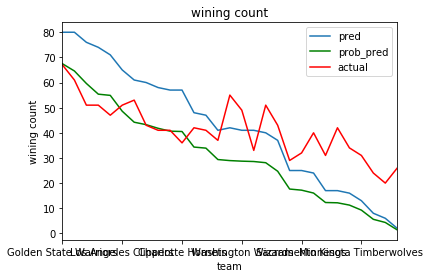

In [147]:
ax = plt.gca()
merged_data.plot(kind='line', x = 'wining_team', y = 'pred',ax=ax)
merged_data.plot(kind='line', x = 'wining_team', y = 'prob_pred', color='green', ax=ax)
merged_data.plot(kind='line', x = 'wining_team', y = 'actual', color='red', ax=ax)

plt.title('wining count')
plt.xlabel('team')
plt.ylabel('wining count')

# the plot gets saved
plt.savefig('wining_count.pdf')

plt.show()

In [160]:
df.set_index("win", inplace=True)

In [162]:
Clevand_win = df.loc[['Cleveland Cavaliers']]
Clevand_win_stat = Clevand_win.groupby('lose').probability.mean().sort_values()
Clevand_win_prediction = pd.DataFrame({'prob_pred':Clevand_win_stat.values,'losing_team':Clevand_win_stat.index})

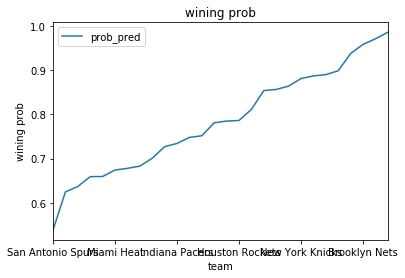

In [163]:
ax = plt.gca()
Clevand_win_prediction.plot(kind='line', x = 'losing_team', y = 'prob_pred',ax=ax)

plt.title('wining prob')
plt.xlabel('team')
plt.ylabel('wining prob')

# the plot gets saved
plt.savefig('wining_prob_Cleveland.pdf')

plt.show()

In [169]:
combined_csv

,Date,Start (ET),Visitor/Neutral,PTS,Home/Neutral,PTS.1,Unnamed: 6,Unnamed: 7,Attend.,Notes,win,lose
0,Tue Oct 25 2016,7:30 PM,New York Knicks,88,Cleveland Cavaliers,117,Box Score,NaN,20562,NaN,Cleveland Cavaliers,New York Knicks
1,Tue Oct 25 2016,10:30 PM,San Antonio Spurs,129,Golden State Warriors,100,Box Score,NaN,19596,NaN,San Antonio Spurs,Golden State Warriors
2,Tue Oct 25 2016,10:00 PM,Utah Jazz,104,Portland Trail Blazers,113,Box Score,NaN,19446,NaN,Portland Trail Blazers,Utah Jazz
3,Wed Oct 26 2016,7:30 PM,Brooklyn Nets,117,Boston Celtics,122,Box Score,NaN,18624,NaN,Boston Celtics,Brooklyn Nets
4,Wed Oct 26 2016,7:00 PM,Dallas Mavericks,121,Indiana Pacers,130,Box Score,OT,17923,NaN,Indiana Pacers,Dallas Mavericks
5,Wed Oct 26 2016,10:30 PM,Houston Rockets,114,Los Angeles Lakers,120,Box Score,NaN,18997,NaN,Los Angeles Lakers,Houston Rockets
6,Wed Oct 26 2016,8:00 PM,Minnesota Timberwolves,98,Memphis Grizzlies,102,Box Score,NaN,18119,NaN,Memphis Grizzlies,Minnesota Timberwolves
7,Wed Oct 26 2016,8:00 PM,Charlotte Hornets,107,Milwaukee Bucks,96,Box Score,NaN,18717,NaN,Charlotte Hornets,Milwaukee Bucks
8,Wed Oct 26 2016,8:00 PM,Denver Nuggets,107,New Orleans Pelicans,102,Box Score,NaN,15869,NaN,Denver Nuggets,New Orleans Pelicans
9,Wed Oct 26 2016,7:00 PM,Miami Heat,108,Orlando Magic,96,Box Score,NaN,19298,NaN,Miami Heat,Orlando Magic


In [175]:
combined_csv['team'] = 0
combined_csv['mark'] = 0

for i in range(len(combined_csv['Visitor/Neutral'])):
    if combined_csv['Visitor/Neutral'][i] == 'Cleveland Cavaliers' or combined_csv['Home/Neutral'][i] == 'Cleveland Cavaliers':
        if combined_csv['win'][i] == 'Cleveland Cavaliers':
            combined_csv['team'][i] = combined_csv['lose'][i]
            combined_csv['mark'][i] = 1
        else:
            combined_csv['team'][i] = combined_csv['win'][i]
            combined_csv['mark'][i] = 0
    else:
        combined_csv['team'][i] = 'NONE'
        combined_csv['mark'][i] = -1
        
         

/Users/brownlab/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/brownlab/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/brownlab/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Users/brownlab/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:14: SettingWit

In [199]:
refined_data = combined_csv.loc[combined_csv['team'] != 'NONE', ['team', 'mark']]

total_count = refined_data.groupby('team').count().reset_index(drop=False)
total_count.columns = ['losing_team', 'mark']
total_count

,losing_team,mark
0,Atlanta Hawks,4
1,Boston Celtics,4
2,Brooklyn Nets,3
3,Charlotte Hornets,4
4,Chicago Bulls,4
5,Dallas Mavericks,2
6,Denver Nuggets,2
7,Detroit Pistons,4
8,Golden State Warriors,2
9,Houston Rockets,2


In [201]:
wining_count_stat = refined_data.groupby('team').mark.sum()

wining_count = pd.DataFrame({'count':wining_count_stat.values,'losing_team':wining_count_stat.index})
wining_count

,count,losing_team
0,1,Atlanta Hawks
1,3,Boston Celtics
2,3,Brooklyn Nets
3,4,Charlotte Hornets
4,0,Chicago Bulls
5,1,Dallas Mavericks
6,1,Denver Nuggets
7,2,Detroit Pistons
8,1,Golden State Warriors
9,1,Houston Rockets


In [202]:
merged_file = pd.merge(wining_count, total_count, on='losing_team')
merged_file['prob'] = merged_file['count']/merged_file['mark']

    

In [203]:
merged_file

,count,losing_team,mark,prob
0,1,Atlanta Hawks,4,0.250000
1,3,Boston Celtics,4,0.750000
2,3,Brooklyn Nets,3,1.000000
3,4,Charlotte Hornets,4,1.000000
4,0,Chicago Bulls,4,0.000000
5,1,Dallas Mavericks,2,0.500000
6,1,Denver Nuggets,2,0.500000
7,2,Detroit Pistons,4,0.500000
8,1,Golden State Warriors,2,0.500000
9,1,Houston Rockets,2,0.500000


In [205]:
merged_together = pd.merge(Clevand_win_prediction, merged_file, on='losing_team')
merged_together

,losing_team,prob_pred,count,mark,prob
0,San Antonio Spurs,0.538332,0,2,0.000000
1,Los Angeles Clippers,0.624363,0,2,0.000000
2,Oklahoma City Thunder,0.636702,1,2,0.500000
3,Toronto Raptors,0.658917,3,4,0.750000
4,Boston Celtics,0.659282,3,4,0.750000
5,Miami Heat,0.673817,1,4,0.250000
6,Atlanta Hawks,0.677750,1,4,0.250000
7,Charlotte Hornets,0.682702,4,4,1.000000
8,Portland Trail Blazers,0.700651,1,2,0.500000
9,Chicago Bulls,0.726830,0,4,0.000000


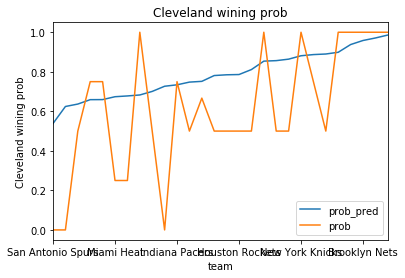

In [206]:
ax = plt.gca()
merged_together.plot(kind='line', x = 'losing_team', y = 'prob_pred',ax=ax)
merged_together.plot(kind='line', x = 'losing_team', y = 'prob',ax=ax)

plt.title('Cleveland wining prob')
plt.xlabel('team')
plt.ylabel('Cleveland wining prob')

# the plot gets saved
plt.savefig('wining_prob_Cleveland.pdf')

plt.show()

In [198]:
Clevand_win_prediction

,losing_team,prob_pred
0,San Antonio Spurs,0.538332
1,Los Angeles Clippers,0.624363
2,Oklahoma City Thunder,0.636702
3,Toronto Raptors,0.658917
4,Boston Celtics,0.659282
5,Miami Heat,0.673817
6,Atlanta Hawks,0.677750
7,Charlotte Hornets,0.682702
8,Portland Trail Blazers,0.700651
9,Chicago Bulls,0.726830
